# Why and When Attention Matters in Reinforcement Learning
> "Using RLlib and AttentionNet to master environments with stateless observations, here, stateless CartPole."

- hide: true
- toc: true
- branch: master
- badges: true
- comments: true
- categories: [python, ray, rllib, tensorflow, machine learning, reinforcement learning, attention]
- image: images/cartpole.jpg

TODOs:
* Image and short explanation of (self-)attention.
* Proper description of different options


In reinforcement learning (RL), the RL agent typically selects a suitable action based on the last observation.
Since many practical environments are stateful, this state should be taken into account when selecting an action.
As an example, consider the popular [OpenAI Gym CartPole environment](https://gym.openai.com/envs/CartPole-v1/),
where the task is to move a cart left or right in order to balance a pole on the cart as long as possible.

![OpenAI Gym CartPole-v1 Environment](attention/cartpole.gif "OpenAI Gym CartPole-v1 Environment")

Whether the cart should be moved left or right clearly depends on how the pole is currently moving,
i.e., in which direction it is swinging and with which velocity.
In this example, the pole's movement and velocity are an important part of the state,
which should determine the selected action (left or right).

In the following, I show different options how to deal with this state.

* State explicitly observed
* State not observed at all
* Sequence of last observations
* Sequence of last observations + attention

For each case, I use PPO with default hyperparamters.

> Tip: Also check out the [RLlib example using AttentionNet](https://github.com/ray-project/ray/blob/master/rllib/examples/attention_net.py).


## Setup

Install Ray RLlib and TensorFlow (also works with PyTorch); seaborn for plotting.
I am using Python 3.8 on Windows 10.

In [2]:
#collapse-output
!pip install ray[rllib]==1.8.0
!pip install tensorflow==2.7.0
!pip install seaborn==0.11.2

Import relevant dependencies and set constants.

In [13]:
import ray
import ray.tune
from ray.rllib.agents import ppo

# adjust num_cpus and num_gpus to your system
# for some reason, num_cpus=2 gets stuck on my system (when trying to train)
ray.init(num_cpus=3, ignore_reinit_error=True)

# stop conditions based on training iterations (each with 4000 train steps)
stop = {"training_iteration": 5}

2021-11-16 18:20:30,686	INFO worker.py:832 -- Calling ray.init() again after it has already been called.


## Explicitly Observe State (Velocity)


The default `CartPole-v1` environment has four observations as described [here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py#L26):
Cart position, cart velocity, pole angle, and pole angular velocity

In [14]:
import gym

env = gym.make("CartPole-v1")
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [15]:
#collapse-output

# load the PPO default config
config = ppo.DEFAULT_CONFIG.copy()
# use the normal, default CartPole-v1 envrion
config["env"] = "CartPole-v1"

# train; this takes a while
results = ray.tune.run("PPO", config=config, stop=stop)
print("Training finished successfully")

Trial name,status,loc
PPO_CartPole-v1_82e0a_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_CartPole-v1_82e0a_00000,PENDING,


(pid=17188) 2021-11-16 18:20:49,461	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=17188) 2021-11-16 18:20:49,462	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=17188) 2021-11-16 18:20:49,462	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=17172) 2021-11-16 18:21:03,326	WARNING deprecation.py:38 -- Deprec

Trial name,status,loc
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188


(pid=17188) 2021-11-16 18:21:06,492	WARNING trainer_template.py:185 -- `execution_plan` functions should accept `trainer`, `workers`, and `config` as args!
(pid=17188) 2021-11-16 18:21:06,492	INFO trainable.py:110 -- Trainable.setup took 17.034 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=17188) 2021-11-16 18:21:06,492	WARNING util.py:57 -- Install gputil for GPU system monitoring.


Trial name,status,loc
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188


(pid=17188) 2021-11-16 18:21:10,976	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188


Result for PPO_CartPole-v1_82e0a_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-16_18-21-15
  done: false
  episode_len_mean: 21.481081081081083
  episode_media: {}
  episode_reward_max: 77.0
  episode_reward_mean: 21.481081081081083
  episode_reward_min: 8.0
  episodes_this_iter: 185
  episodes_total: 185
  experiment_id: 95780d6ad71a4a26be1d679814f7cb8b
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6670995354652405
          entropy_coeff: 0.0
          kl: 0.0263509601354599
          model: {}
          policy_loss: -0.04095163196325302
          total_loss: 175.8995361328125
          vf_explained_var: -0.0022988677956163883
          vf_loss: 175.93521118164062
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained: 4000

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188,1,9.4548,4000,21.4811,77,8,21.4811


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188,1,9.4548,4000,21.4811,77,8,21.4811


Result for PPO_CartPole-v1_82e0a_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-11-16_18-21-24
  done: false
  episode_len_mean: 44.09
  episode_media: {}
  episode_reward_max: 139.0
  episode_reward_mean: 44.09
  episode_reward_min: 10.0
  episodes_this_iter: 79
  episodes_total: 264
  experiment_id: 95780d6ad71a4a26be1d679814f7cb8b
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.6171236038208008
          entropy_coeff: 0.0
          kl: 0.016787048429250717
          model: {}
          policy_loss: -0.03248118236660957
          total_loss: 416.99993896484375
          vf_explained_var: 0.05350838229060173
          vf_loss: 417.02740478515625
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained: 8000
    num_steps_trained_th

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188,2,18.1136,8000,44.09,139,10,44.09


Result for PPO_CartPole-v1_82e0a_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-11-16_18-21-33
  done: false
  episode_len_mean: 69.38
  episode_media: {}
  episode_reward_max: 425.0
  episode_reward_mean: 69.38
  episode_reward_min: 10.0
  episodes_this_iter: 38
  episodes_total: 302
  experiment_id: 95780d6ad71a4a26be1d679814f7cb8b
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5824630856513977
          entropy_coeff: 0.0
          kl: 0.011254677549004555
          model: {}
          policy_loss: -0.021928098052740097
          total_loss: 694.076904296875
          vf_explained_var: 0.09451597183942795
          vf_loss: 694.095458984375
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_trained: 12000
    num_steps_trained_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188,3,27.2399,12000,69.38,425,10,69.38


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188,3,27.2399,12000,69.38,425,10,69.38


Result for PPO_CartPole-v1_82e0a_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-11-16_18-21-41
  done: false
  episode_len_mean: 97.77
  episode_media: {}
  episode_reward_max: 425.0
  episode_reward_mean: 97.77
  episode_reward_min: 10.0
  episodes_this_iter: 19
  episodes_total: 321
  experiment_id: 95780d6ad71a4a26be1d679814f7cb8b
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.570598304271698
          entropy_coeff: 0.0
          kl: 0.006147594656795263
          model: {}
          policy_loss: -0.01379616279155016
          total_loss: 804.7181396484375
          vf_explained_var: 0.2031535804271698
          vf_loss: 804.7300415039062
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    num_steps_trained_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188,4,35.0285,16000,97.77,425,10,97.77


Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_82e0a_00000,RUNNING,127.0.0.1:17188,4,35.0285,16000,97.77,425,10,97.77


Result for PPO_CartPole-v1_82e0a_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-11-16_18-21-49
  done: true
  episode_len_mean: 133.09
  episode_media: {}
  episode_reward_max: 500.0
  episode_reward_mean: 133.09
  episode_reward_min: 10.0
  episodes_this_iter: 12
  episodes_total: 333
  experiment_id: 95780d6ad71a4a26be1d679814f7cb8b
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.30000001192092896
          cur_lr: 4.999999873689376e-05
          entropy: 0.5628640651702881
          entropy_coeff: 0.0
          kl: 0.0053915660828351974
          model: {}
          policy_loss: -0.012018542736768723
          total_loss: 663.389892578125
          vf_explained_var: 0.19897815585136414
          vf_loss: 663.4002685546875
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    num_steps_train

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_CartPole-v1_82e0a_00000,TERMINATED,127.0.0.1:17188,5,43.2415,20000,133.09,500,10,133.09


(pid=17188) [2021-11-16 18:21:50,089 E 17188 8580] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=17188) Windows fatal exception: access violation
(pid=17188) 
(pid=17172) [2021-11-16 18:21:50,106 C 17172 1512] core_worker.cc:2234:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=17172) *** StackTrace Information ***
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyInit__raylet
(pid=17172)     PyNumber_InPlaceLshift
(pid=17172)     Py_CheckFunctionResult
(pid=17172)     PyEval_EvalFrameDefault
(pid=17172)     Py_CheckFunction

Training finished successfully


In [16]:
# check results
results.default_metric = "episode_reward_mean"
results.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results.best_result["episode_reward_mean"]

133.09

In [25]:
results.dataframe()

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,num_healthy_workers,timesteps_total,timesteps_this_iter,agent_timesteps_total,done,...,config/synchronize_filters,config/tf_session_args,config/timesteps_per_iteration,config/train_batch_size,config/use_critic,config/use_gae,config/vf_clip_param,config/vf_loss_coeff,config/vf_share_layers,logdir
0,500.0,10.0,133.09,133.09,12,2,20000,0,20000,True,...,True,"{'allow_soft_placement': True, 'device_count':...",0,4000,True,True,10.0,1.0,-1,C:\Users\Stefan\ray_results\PPO\PPO_CartPole-v...


c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

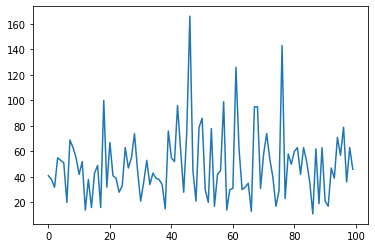

In [29]:

import seaborn as sns


eps_lengths = results.best_result["hist_stats"]["episode_lengths"]
eps = [i for i in range(len(eps_lengths))]
sns.scatterplot(eps, eps_lengths)

## Do Not Observe Velocity

In many practical

In [26]:
from ray.rllib.examples.env.stateless_cartpole import StatelessCartPole
from ray.tune import registry

registry.register_env("StatelessCartPole", lambda _: StatelessCartPole())
config["env"] = "StatelessCartPole"
# train; this takes a while
results = ray.tune.run("PPO", config=config, stop=stop)
print("Training finished successfully")

Trial name,status,loc
PPO_StatelessCartPole_38798_00000,PENDING,


(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)


Trial name,status,loc
PPO_StatelessCartPole_38798_00000,PENDING,


(pid=7440) 2021-11-16 18:33:04,342	INFO trainer.py:753 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=7440) 2021-11-16 18:33:04,342	INFO ppo.py:166 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
(pid=7440) 2021-11-16 18:33:04,342	INFO trainer.py:770 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=None) c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\redis\connection.py:77: UserWarning: redis-py works best with hiredis. Please consider installing
(pid=None)   warnings.warn(msg)
(pid=284) 2021-11-16 18:33:18,156	WARNING deprecation.py:38 -- Deprecation

Trial name,status,loc
PPO_StatelessCartPole_38798_00000,RUNNING,127.0.0.1:7440


Trial name,status,loc
PPO_StatelessCartPole_38798_00000,RUNNING,127.0.0.1:7440


(pid=7440) 2021-11-16 18:33:24,010	WARNING deprecation.py:38 -- DeprecationWarning: `slice` has been deprecated. Use `SampleBatch[start:stop]` instead. This will raise an error in the future!


Trial name,status,loc
PPO_StatelessCartPole_38798_00000,RUNNING,127.0.0.1:7440


Result for PPO_StatelessCartPole_38798_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2021-11-16_18-33-27
  done: false
  episode_len_mean: 22.105555555555554
  episode_media: {}
  episode_reward_max: 68.0
  episode_reward_mean: 22.105555555555554
  episode_reward_min: 8.0
  episodes_this_iter: 180
  episodes_total: 180
  experiment_id: 00eced3f242b47f9acdfe84b0105571c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6810067296028137
          entropy_coeff: 0.0
          kl: 0.012460388243198395
          model: {}
          policy_loss: -0.024759571999311447
          total_loss: 154.19677734375
          vf_explained_var: -0.002643636194989085
          vf_loss: 154.21905517578125
    num_agent_steps_sampled: 4000
    num_agent_steps_trained: 4000
    num_steps_sampled: 4000
    num_steps_trained

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_38798_00000,RUNNING,127.0.0.1:7440,1,7.11869,4000,22.1056,68,8,22.1056


Result for PPO_StatelessCartPole_38798_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2021-11-16_18-33-34
  done: false
  episode_len_mean: 28.557142857142857
  episode_media: {}
  episode_reward_max: 99.0
  episode_reward_mean: 28.557142857142857
  episode_reward_min: 9.0
  episodes_this_iter: 140
  episodes_total: 320
  experiment_id: 00eced3f242b47f9acdfe84b0105571c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.6480510830879211
          entropy_coeff: 0.0
          kl: 0.010690557770431042
          model: {}
          policy_loss: -0.0200344268232584
          total_loss: 161.2119903564453
          vf_explained_var: 0.013951760716736317
          vf_loss: 161.2299041748047
    num_agent_steps_sampled: 8000
    num_agent_steps_trained: 8000
    num_steps_sampled: 8000
    num_steps_trained: 

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_38798_00000,RUNNING,127.0.0.1:7440,2,13.9313,8000,28.5571,99,9,28.5571


Result for PPO_StatelessCartPole_38798_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2021-11-16_18-33-41
  done: false
  episode_len_mean: 37.345794392523366
  episode_media: {}
  episode_reward_max: 97.0
  episode_reward_mean: 37.345794392523366
  episode_reward_min: 10.0
  episodes_this_iter: 107
  episodes_total: 427
  experiment_id: 00eced3f242b47f9acdfe84b0105571c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.604137659072876
          entropy_coeff: 0.0
          kl: 0.007240870501846075
          model: {}
          policy_loss: -0.009266306646168232
          total_loss: 162.28103637695312
          vf_explained_var: 0.029492605477571487
          vf_loss: 162.28884887695312
    num_agent_steps_sampled: 12000
    num_agent_steps_trained: 12000
    num_steps_sampled: 12000
    num_steps_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_38798_00000,RUNNING,127.0.0.1:7440,3,20.6711,12000,37.3458,97,10,37.3458


Result for PPO_StatelessCartPole_38798_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2021-11-16_18-33-47
  done: false
  episode_len_mean: 46.53
  episode_media: {}
  episode_reward_max: 168.0
  episode_reward_mean: 46.53
  episode_reward_min: 9.0
  episodes_this_iter: 79
  episodes_total: 506
  experiment_id: 00eced3f242b47f9acdfe84b0105571c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.20000000298023224
          cur_lr: 4.999999873689376e-05
          entropy: 0.5635395646095276
          entropy_coeff: 0.0
          kl: 0.003835817100480199
          model: {}
          policy_loss: -0.005301193334162235
          total_loss: 229.7139129638672
          vf_explained_var: 0.10358849167823792
          vf_loss: 229.71847534179688
    num_agent_steps_sampled: 16000
    num_agent_steps_trained: 16000
    num_steps_sampled: 16000
    num_steps_trained: 16000
    num_steps_

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_38798_00000,RUNNING,127.0.0.1:7440,4,27.3544,16000,46.53,168,9,46.53


Result for PPO_StatelessCartPole_38798_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2021-11-16_18-33-54
  done: true
  episode_len_mean: 49.42
  episode_media: {}
  episode_reward_max: 166.0
  episode_reward_mean: 49.42
  episode_reward_min: 11.0
  episodes_this_iter: 80
  episodes_total: 586
  experiment_id: 00eced3f242b47f9acdfe84b0105571c
  hostname: nb-stschn
  info:
    learner:
      default_policy:
        custom_metrics: {}
        learner_stats:
          cur_kl_coeff: 0.10000000149011612
          cur_lr: 4.999999873689376e-05
          entropy: 0.5414723753929138
          entropy_coeff: 0.0
          kl: 0.00503366207703948
          model: {}
          policy_loss: -0.008636890910565853
          total_loss: 251.0379638671875
          vf_explained_var: 0.11828897148370743
          vf_loss: 251.04611206054688
    num_agent_steps_sampled: 20000
    num_agent_steps_trained: 20000
    num_steps_sampled: 20000
    num_steps_trained: 20000
    num_steps_t

Trial name,status,loc,iter,total time (s),ts,reward,episode_reward_max,episode_reward_min,episode_len_mean
PPO_StatelessCartPole_38798_00000,TERMINATED,127.0.0.1:7440,5,34.0887,20000,49.42,166,11,49.42


(pid=7440) [2021-11-16 18:33:55,327 E 7440 8396] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=7440) Windows fatal exception: access violation
(pid=7440) 
(pid=284) [2021-11-16 18:33:55,329 E 284 18192] raylet_client.cc:159: IOError: Unknown error [RayletClient] Failed to disconnect from raylet.
(pid=284) Windows fatal exception: access violation
(pid=284) 
2021-11-16 18:33:55,436	INFO tune.py:630 -- Total run time: 65.48 seconds (64.87 seconds for the tuning loop).


Training finished successfully


(pid=16636) [2021-11-16 18:33:55,354 C 16636 21336] core_worker.cc:796:  Check failed: _s.ok() Bad status: IOError: Unknown error
(pid=16636) *** StackTrace Information ***
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyInit__raylet
(pid=16636)     PyNumber_InPlaceLshift
(pid=16636)     Py_CheckFunctionResult
(pid=16636)     PyEval_EvalFrameDefault
(pid=16636)     Py_CheckFunctionResult
(pid=16636)     PyEval_EvalFrameDefault
(pid=16636)     PyEval_EvalCodeWithName
(pid=16636)     PyEval_EvalCodeEx
(pid=16636)     PyEval_EvalCode
(pid=16636)     PyArena_New


In [27]:
# check results
results.default_metric = "episode_reward_mean"
results.default_mode = "max"
# print the mean episode reward = episode length --> higher = better
results.best_result["episode_reward_mean"]

49.42

c:\users\stefan\git-repos\private\blog\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

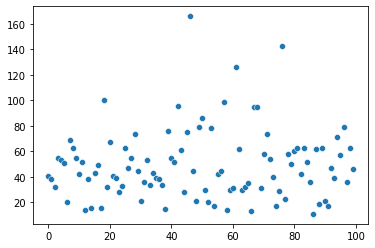

In [30]:
eps_lengths = results.best_result["hist_stats"]["episode_lengths"]
eps = [i for i in range(len(eps_lengths))]
sns.scatterplot(eps, eps_lengths)

## Stacked Observations with Attention

TODO: continue here
https://github.com/ray-project/ray/blob/master/rllib/examples/attention_net.py